In [3]:
import os
import astropy.io.fits as fits
import pandas as pd
import numpy as np
from pathlib import Path, PurePath
import matplotlib.pyplot as plt
import sunpy.visualization.colormaps
import matplotlib.colors as colors
import seaborn as sns
pd.options.mode.chained_assignment = None

FS = 16

In [51]:
def get_dist_mat(coords):
    coords_x = coords % 4096
    coords_y = coords // 4096
    coords_xb = coords_x[:, np.newaxis]
    coords_yb = coords_y[:, np.newaxis]
    dx_broadc = coords_x - coords_xb
    dy_broadc = coords_y - coords_yb
    dist_matrix = dx_broadc**2 + dy_broadc**2
    return dist_matrix

def get_rows_list(array, w1_idx, w2_idx):
    np_mask = (array[:, w1_idx] == 1) & (array[:, w2_idx] == 1)
    df_idx = np.nonzero(np_mask)[0]
    coords = array[np_mask, 0]
    dist_matrix = get_dist_mat(coords)
    select = dist_matrix < 2 
    select2 = np.triu(select, k=1)
    r,c = np.nonzero(select2)
    idx1, idx2 = df_idx[r], df_idx[c]
    return idx1, idx2


def get_df_min_overlaps(df, n_overlaps):
    df_overlap_counts = df.loc[df['overlaps']>=n_overlaps].groupby(level=0)['overlaps'].count().rename(f'{n_overlaps}-overlap').to_frame()
    df_overlap_counts['Time'] = gdates.loc[df_overlap_counts.index]
    df_overlap_counts.set_index('Time', inplace=True)
    return df_overlap_counts
    

def get_df_overlaps(df, n_overlaps):
    df_overlap_counts = df.loc[df['overlaps']==n_overlaps].groupby(level=0)['overlaps'].count().rename(f'{n_overlaps}-overlap').to_frame()
    df_overlap_counts['Time'] = gdates.loc[df_overlap_counts.index]
    df_overlap_counts.set_index('Time', inplace=True)
    return df_overlap_counts


def get_2coincidentals(array, w1_idx, w2_idx):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    records = [df0.loc[[i1, i2]][['coords', 'int1', 'int2', 'wref']] for i1, i2 in zip(idx1, idx2)]
    df_records = pd.concat(records, keys=list(range(len(records))))
    return df_records


def get_2clusters(array, w1_idx, w2_idx, group_n=None):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    # To remove conjugates
#     keep_mask = arr0[idx1, 3] != arr0[idx2, 3] 
#     recordsf = np.concatenate((arr0[idx1[keep_mask], 0:4], arr0[idx2[keep_mask], 0:4]), axis=1)
    
    records = np.concatenate((array[idx1, 0:4], array[idx2, 0:4]), axis=1)
    df_records = pd.DataFrame(records, columns=['coords1', 'int1_before', 'int1_after', 'wref1', 'coords2', 'int2_before', 'int2_after', 'wref2'])
    if group_n is not None:
        df_records['GroupNumber'] = group_n
    
    return df_records


def get_3clusters(array, w1_idx, w2_idx, w3_idx, group_n=None):
    df12 = get_2clusters(array, w1_idx, w2_idx, group_n=group_n)
    df13 = get_2clusters(array, w1_idx, w3_idx, group_n=group_n)
    series123 = df12['coords1'].loc[df12['coords1'].isin(df13['coords1'])]
    return series123




In [29]:
data_dir = os.environ['SPIKESDATA']
spikes_db = pd.read_parquet(os.path.join(data_dir, 'spikes_df_2010.parquet'), engine='pyarrow')
print(len(spikes_db))
spikes_db.head(8)

50386


Path   Size  \
0  2010/07/12/2010-07-12T00h00m00.57Z_0171.spikes...  25920   
1  2010/07/12/2010-07-12T00h00m02.07Z_0211.spikes...  37440   
2  2010/07/12/2010-07-12T00h00m03.57Z_0304.spikes...  63360   
3  2010/07/12/2010-07-12T00h00m05.05Z_0335.spikes...  80640   
4  2010/07/12/2010-07-12T00h00m08.05Z_0193.spikes...  28800   
5  2010/07/12/2010-07-12T00h00m09.59Z_0094.spikes...  69120   
6  2010/07/12/2010-07-12T00h00m11.05Z_0131.spikes...  69120   
7  2010/07/12/2010-07-12T00h00m12.55Z_0171.spikes...  25920   

                              Time  Wavelength  GroupNumber  
0 2010-07-12 00:00:00.570000+00:00         171            0  
1 2010-07-12 00:00:02.070000+00:00         211            0  
2 2010-07-12 00:00:03.570000+00:00         304            0  
3 2010-07-12 00:00:05.050000+00:00         335            0  
4 2010-07-12 00:00:08.050000+00:00         193            0  
5 2010-07-12 00:00:09.590000+00:00          94            0  
6 2010-07-12 00:00:11.050000+00:00         131            0  
7 2010-07-12 00:00:12.550000+00:00         171            1

### Map the group number to a timestamp. Arbitrary choice: choose the 1st file in the group. 

In [30]:
gdates = spikes_db.groupby('GroupNumber').nth(0)[['GroupNumber', 'Time']]
gdates.set_index('GroupNumber', inplace=True)
gdates.head()

Time
GroupNumber                                 
0           2010-07-12 00:00:00.570000+00:00
1           2010-07-12 00:00:12.550000+00:00
2           2010-07-12 00:00:24.580000+00:00
3           2010-07-12 00:00:36.550000+00:00
4           2010-07-12 00:00:48.570000+00:00

In [86]:
spikes_db2 = pd.read_parquet(os.path.join(data_dir, 'spikes_df_2010_backup.parquet'), engine='pyarrow')

In [90]:
tstart = pd.Timestamp('2010-07-12 00:00:00', tz='UTC')
tend = pd.Timestamp('2010-07-13 00:00:00', tz='UTC')
tmask = (spikes_db2['Time'] >= tstart) & (spikes_db2['Time'] < tend)
spikes_db2 = spikes_db2[tmask]

In [97]:
print(len(spikes_db2))
spikes_db2.head(14)

50386


Path   Size  \
2995649  2010/07/12/2010-07-12T00:00:00.57Z_0171.spikes...  25920   
2995650  2010/07/12/2010-07-12T00:00:02.07Z_0211.spikes...  37440   
2995651  2010/07/12/2010-07-12T00:00:03.57Z_0304.spikes...  63360   
2995652  2010/07/12/2010-07-12T00:00:05.05Z_0335.spikes...  80640   
2995653  2010/07/12/2010-07-12T00:00:08.05Z_0193.spikes...  28800   
2995654  2010/07/12/2010-07-12T00:00:09.59Z_0094.spikes...  69120   
2995655  2010/07/12/2010-07-12T00:00:11.05Z_0131.spikes...  69120   
2995656  2010/07/12/2010-07-12T00:00:12.55Z_0171.spikes...  25920   
2995657  2010/07/12/2010-07-12T00:00:14.08Z_0211.spikes...  40320   
2995658  2010/07/12/2010-07-12T00:00:15.58Z_0304.spikes...  69120   
2995659  2010/07/12/2010-07-12T00:00:17.08Z_0335.spikes...  77760   
2995660  2010/07/12/2010-07-12T00:00:20.07Z_0193.spikes...  25920   
2995661  2010/07/12/2010-07-12T00:00:21.58Z_0094.spikes...  66240   
2995662  2010/07/12/2010-07-12T00:00:23.07Z_0131.spikes...  66240   

                                    Time  Wavelength  GroupNumber  
2995649 2010-07-12 00:00:00.570000+00:00         171       432000  
2995650 2010-07-12 00:00:02.070000+00:00         211       432000  
2995651 2010-07-12 00:00:03.570000+00:00         304       432000  
2995652 2010-07-12 00:00:05.050000+00:00         335       432000  
2995653 2010-07-12 00:00:08.050000+00:00         193       432000  
2995654 2010-07-12 00:00:09.590000+00:00          94       432000  
2995655 2010-07-12 00:00:11.050000+00:00         131       432000  
2995656 2010-07-12 00:00:12.550000+00:00         171       432001  
2995657 2010-07-12 00:00:14.080000+00:00         211       432001  
2995658 2010-07-12 00:00:15.580000+00:00         304       432001  
2995659 2010-07-12 00:00:17.080000+00:00         335       432001  
2995660 2010-07-12 00:00:20.070000+00:00         193       432001  
2995661 2010-07-12 00:00:21.580000+00:00          94       432001  
2995662 2010-07-12 00:00:23.070000+00:00         131       432001

### Load a parquet file (1 day of data). This is the result of the preprocessing that runs through all the individual fits files to only keep those coordinates where at least one nearest neighbour was found in any of the 6 other wavelengths. 

The index (GroupNumber) map to a timestamp. Same GroupNumber are for observations taken at the same time. 

#### columns are: 
- coords:1D coordinates of a 4096 x 4096 image array
- int1, int2: intensity before interpolation, intensity after interpolation
- wref: reference wavelength number of that coordinate (from 0 to 6)
- w0, ... w6: binary (1 or 0) telling whether that coordinate has a nearest neighbour in those wavelengths. 

If for a given coordinate wref = 3, then by definition w3 = 1, and there will be at least one the other wavelength with a True value (1), and that "conjugate" or "neighbour" will be found somehwere further down that list and sharing the same GroupNumber (as it belonged to the same file recorded at the same time). 

In [95]:
parquet_dir = Path(os.environ['SPIKESDATA'], '2010', '07')
df0 = pd.read_parquet(Path(parquet_dir, 'df_coincidentals_2010_07_12.parquet'), engine='pyarrow')
df0.insert(2, 'x', df0['coords']%4096)
df0.insert(3, 'y', df0['coords']//4096)
df0.set_index('GroupNumber', inplace=True)
df0.head()

coords     x   y  int1  int2  wref  w0  w1  w2  w3  w4  w5  w6  \
GroupNumber                                                                   
0            142121  2857  34    63     9     0   1   0   0   0   0   1   0   
0            164350   510  40    49     0     0   1   0   0   1   0   0   0   
0            267298  1058  65    68     8     0   1   0   0   1   0   0   0   
0            297326  2414  72    73    15     0   1   0   0   0   1   0   0   
0            349885  1725  85    54    20     0   1   0   0   0   0   1   0   

             overlaps  
GroupNumber            
0                   2  
0                   2  
0                   2  
0                   2  
0                   2

In [96]:
df0[df0['coords']==63998]

coords     x   y  int1  int2  wref  w0  w1  w2  w3  w4  w5  w6  \
GroupNumber                                                                   
283           63998  2558  15   355     0     3   0   0   1   1   0   0   0   
3643          63998  2558  15    17     0     6   0   0   0   1   0   0   1   

             overlaps  
GroupNumber            
283                 2  
3643                2

### Out of these data above, we want to collect all blobs of spatially connected pixels with 8-connectivity for a given combination of wavelengths. We don't want to compute and store all of them, but being able to ask for one of the combination. At this stage, intensity is a dimension that is not relevant and not used for now. 

E.g: What are the cluster of coordinates within 1 pixel of each other observed with a given combination of wavelengths
- (w0, w1, w2)
- (w0, w1, w3)
- (w0, w1, w4)
- (w0, w3, w5, w6)
- ...
- {w0, w1, w3, w4, w5, w6, w7}

In [35]:
c = df0.groupby(level=0).size().rename('total count (>= 2-wave-overlap)')
c.head()

GroupNumber
0    2506
1    2588
2    2558
3    2354
4    2672
Name: total count (>= 2-wave-overlap), dtype: int64

In [39]:
c3 = df0.loc[df0['overlaps']==3].groupby(level=0).size().rename('3-wave-overlap count')
c3.head()

GroupNumber
0    30
1    40
2    29
3    31
4    28
Name: 3-wave-overlap count, dtype: int64

In [37]:
dfcount = pd.concat([gdates.loc[c.index], c, c3], axis=1)
dfcount.set_index('Time', inplace=True)
dfcount.head()

total count (>= 2-wave-overlap)  \
Time                                                                
2010-07-12 00:00:00.570000+00:00                             2506   
2010-07-12 00:00:12.550000+00:00                             2588   
2010-07-12 00:00:24.580000+00:00                             2558   
2010-07-12 00:00:36.550000+00:00                             2354   
2010-07-12 00:00:48.570000+00:00                             2672   

                                  3-wave-overlap count  
Time                                                    
2010-07-12 00:00:00.570000+00:00                  30.0  
2010-07-12 00:00:12.550000+00:00                  40.0  
2010-07-12 00:00:24.580000+00:00                  29.0  
2010-07-12 00:00:36.550000+00:00                  31.0  
2010-07-12 00:00:48.570000+00:00                  28.0

In [52]:
df_counts_list= [get_df_overlaps(df0, n) for n in range(2, 8)]

In [53]:
df_counts = pd.concat(df_counts_list, axis=1)
# Fill the NaN values with zeros
df_counts.fillna(0, inplace=True)
df_counts = df_counts.astype(int)
df_counts.head()

2-overlap  3-overlap  4-overlap  5-overlap  \
Time                                                                           
2010-07-12 00:00:00.570000+00:00       2470         30          6          0   
2010-07-12 00:00:12.550000+00:00       2548         40          0          0   
2010-07-12 00:00:24.580000+00:00       2529         29          0          0   
2010-07-12 00:00:36.550000+00:00       2323         31          0          0   
2010-07-12 00:00:48.570000+00:00       2644         28          0          0   

                                  6-overlap  7-overlap  
Time                                                    
2010-07-12 00:00:00.570000+00:00          0          0  
2010-07-12 00:00:12.550000+00:00          0          0  
2010-07-12 00:00:24.580000+00:00          0          0  
2010-07-12 00:00:36.550000+00:00          0          0  
2010-07-12 00:00:48.570000+00:00          0          0

<Axes: xlabel='Time'>

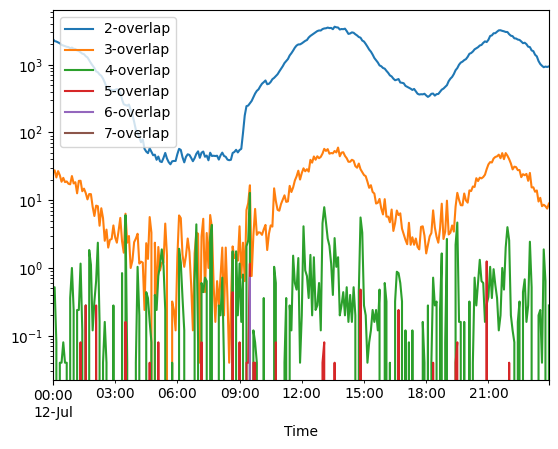

In [55]:
df_counts.resample('5min').mean().plot(y=['2-overlap', '3-overlap', '4-overlap', '5-overlap', '6-overlap', '7-overlap'], 
                                       kind='line', legend='True', logy=True)

In [10]:
dfs = [df0.copy(),]
for n in range(3,8):
    print('n= ', n)
    new_df=dfs[n-3].loc[dfs[n-3]['overlaps'] >=n].copy()
    dfs.append(new_df)

n=  3
n=  4
n=  5
n=  6
n=  7


In [11]:
for n in range(2, 8):
    dfs[n-2].rename(columns={'overlaps':'min_overlaps'}, inplace=True)
    dfs[n-2]['min_overlaps'].loc[:] = n
    
df_overlaps = pd.concat(dfs).reset_index(drop=True)
df_overlaps.head()

GroupNumber  coords     x   y  min_overlaps
0            1  149558  2102  36             2
1            1  205896  1096  50             2
2            1  209992  1096  51             2
3            1  239694  2126  58             2
4            1  348983   823  85             2

In [57]:
img = fits.getdata(Path('FITS', 'aia.lev1.171A_2010-07-11T23_59_59.12Z.image_lev1.fits'))

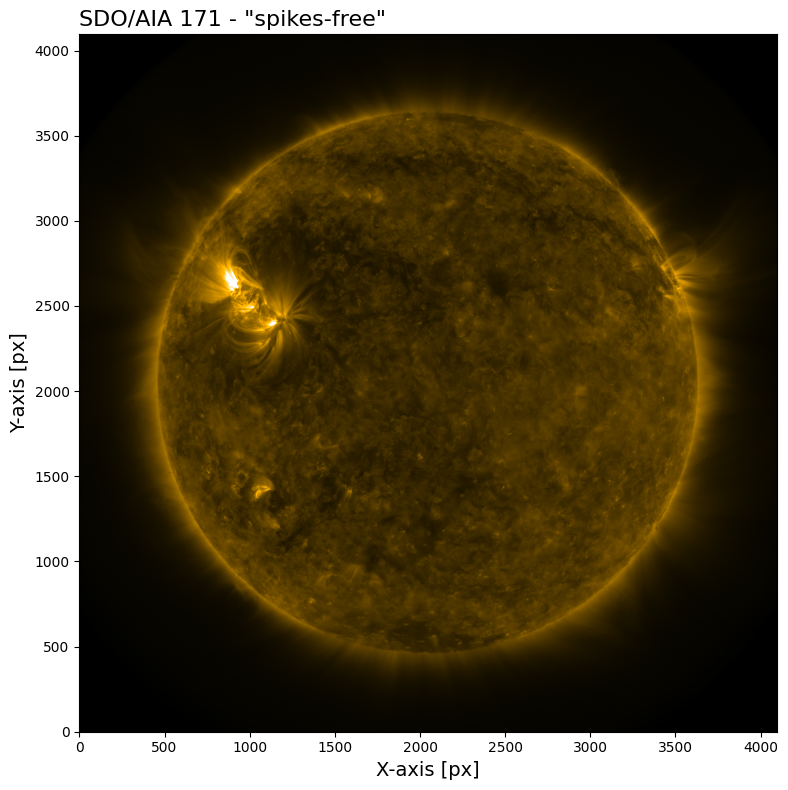

In [58]:
# Image constant and sample FITS image
r_sun = 1578
crpix = 2048.5
nx = 4096
ny = 4096

cmap = plt.get_cmap('sdoaia171')

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)))

plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_xlabel('X-axis [px]', fontsize=FS-2)
ax.set_ylabel('Y-axis [px]', fontsize=FS-2)
ax.set_title('SDO/AIA 171 - "spikes-free"', loc='left', fontsize=FS)

plt.tight_layout()
# plt.savefig('figures/cleaned_image.png', dpi=120)

In [14]:
# Read 1 minutes of raw spikes files
tstart = pd.Timestamp('2018-01-01 00:00:00', tz='UTC')
tend = pd.Timestamp('2018-01-01 04:00:00', tz='UTC')
paths = spikes_db[spikes_db['Wavelength']==171].set_index('Time').loc[tstart:tend]['Path'].apply(
    lambda s:Path(os.environ['SPIKESDATA'], s))
print(paths.head())

spikes = pd.concat([pd.DataFrame(fits.getdata(f).T, columns=['coords', 'int1', 'int2']) for f in paths])
spikes['x'] = spikes['coords'] % 4096
spikes['y'] = spikes['coords'] // 4096
print(spikes.head())

Time
2018-01-01 00:00:10.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:22.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:34.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:46.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:58.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
Name: Path, dtype: object
   coords  int1  int2     x  y
0    9376    39     4  1184  2
1   11091   282     6  2899  2
2   15057   129     5  2769  3
3   17595   369     4  1211  4
4   19152    50     4  2768  4


In [26]:
groups = gdates[(gdates['Time'] >= tstart) & (gdates['Time'] < tend)].index

overlaps_trange = df_overlaps[['GroupNumber', 'coords', 'x', 'y', 'min_overlaps']].set_index('GroupNumber').loc[groups]
print(overlaps_trange['min_overlaps'].max())
overlaps_trange.head()

4


coords     x   y  min_overlaps
GroupNumber                                
1            149558  2102  36             2
1            205896  1096  50             2
1            209992  1096  51             2
1            239694  2126  58             2
1            348983   823  85             2

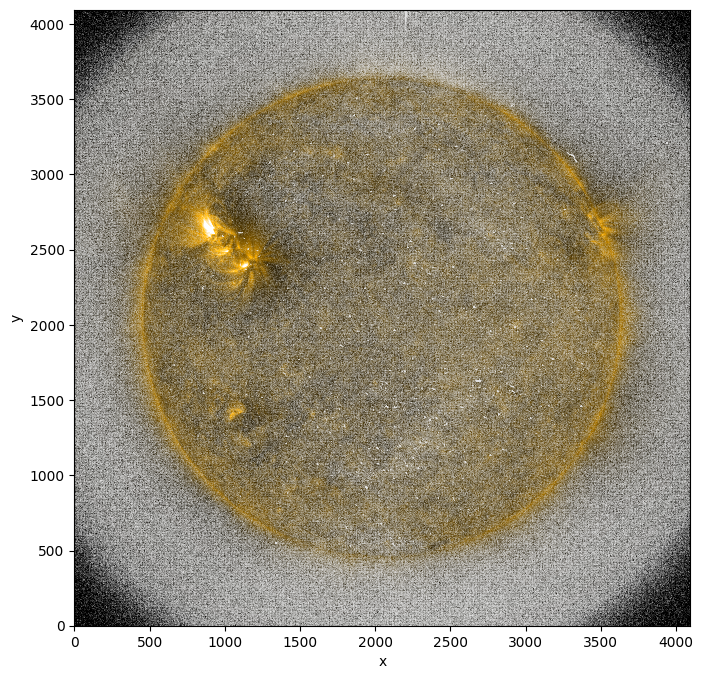

In [61]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df0, x='x', y='y', ax=ax, color='white', s=1, alpha=0.03)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

In [ ]:
# groups = gdates[(gdates['Time'] >= tstart) & (gdates['Time'] < tend)].index
# spikes_w5 = df_overlaps.query('w5==1').set_index('GroupNumber').loc[groups]
# print(spikes_w5['min_overlaps'].max())
# spikes_w5.head()

(0.0, 4095.0)

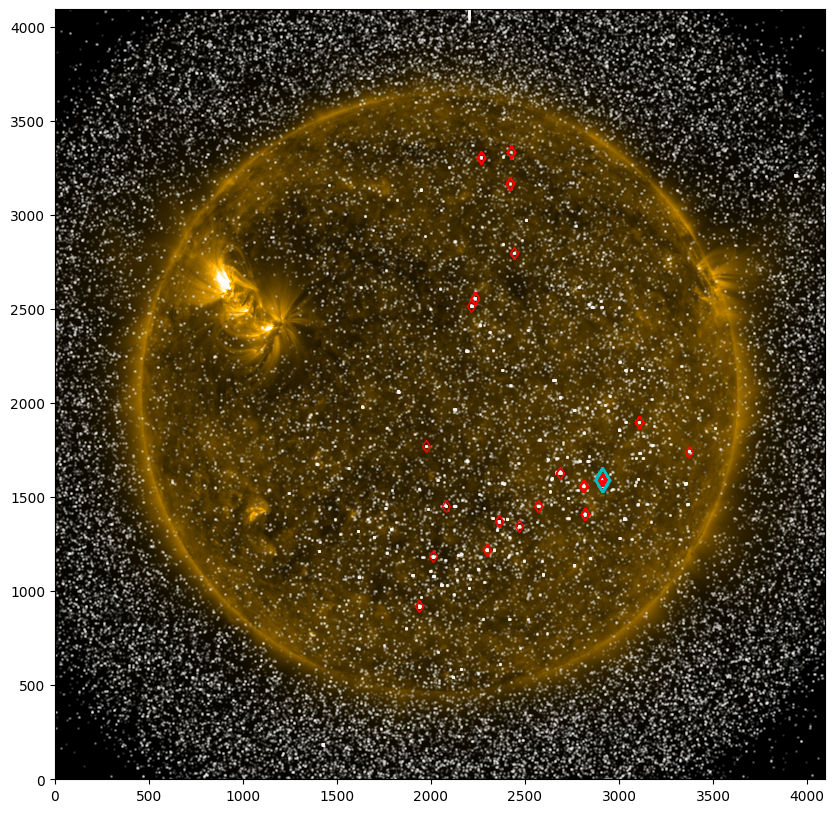

In [85]:
df0_3 = df0.query('overlaps==3')
df0_4 = df0.query('overlaps==4')
df0_5 = df0.query('overlaps==5')
df0_6 = df0.query('overlaps==6')
df0_7 = df0.query('overlaps==7')

fig, ax = plt.subplots(figsize=(10, 10))
# sns.scatterplot(data=df0.query('overlaps==3'), x='x', y='y', ax=ax, color='white', s=1, alpha=0.5)
# sns.scatterplot(data=df0.query('overlaps==5'), x='x', y='y', ax=ax, marker='d', color='red', s=20, alpha=1)


plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

plt.plot(df0_3.x, df0_3.y, 'w.', ms=2, label='all spikes', zorder=1, alpha=0.1)
# plt.plot(df0_4.x, df0_4.y, 'gd', ms=6, label='all spikes', markerfacecolor='none', zorder=2)
plt.plot(df0_5.x, df0_5.y, 'rd', ms=6, label='all spikes', markerfacecolor='none', zorder=3)
plt.plot(df0_6.x, df0_6.y, 'cd', ms=12, label='all spikes', markerfacecolor='none', zorder=4)
plt.plot(df0_7.x, df0_7.y, 'cd', ms=12, label='all spikes', markerfacecolor='none', zorder=5)

plt.xlim(0, nx-1)
plt.ylim(0, ny-1)

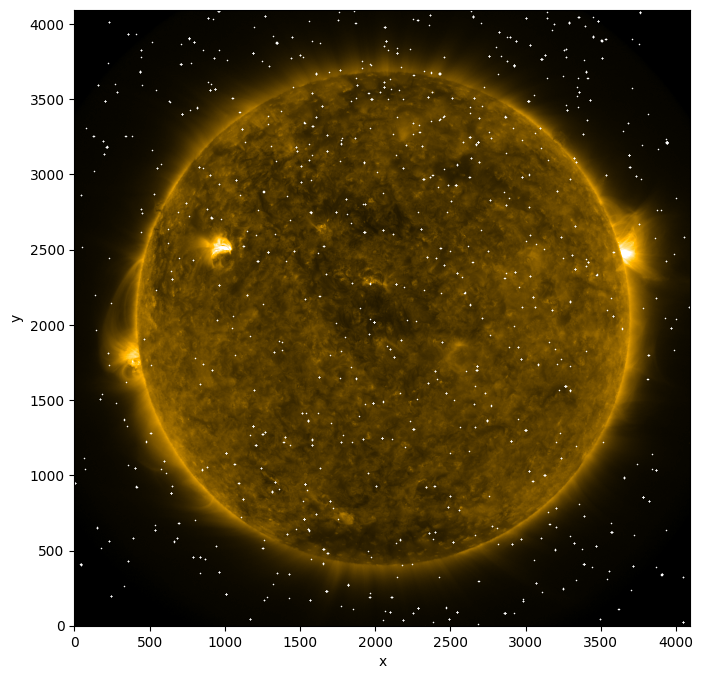

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=overlaps_trange.query('min_overlaps==3').drop_duplicates(subset='coords'), x='x', y='y', ax=ax, color='white', s=1, alpha=1)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

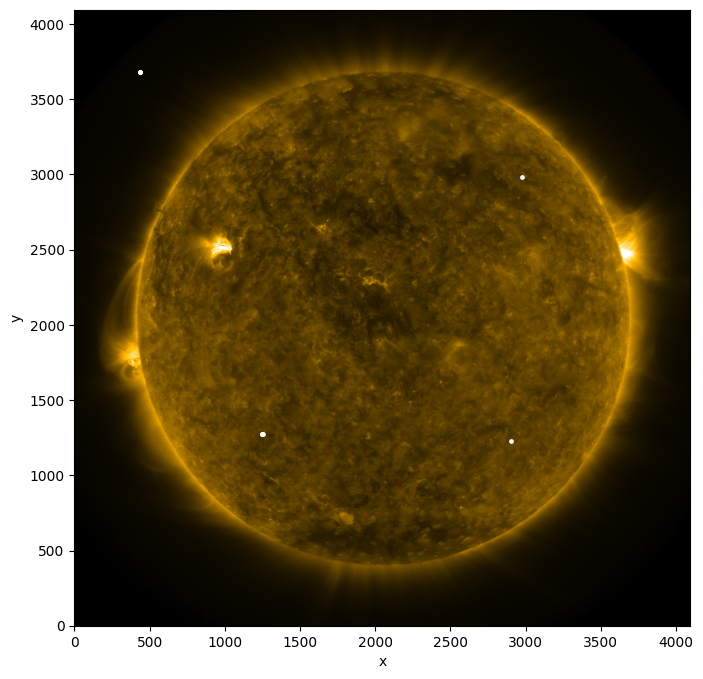

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=overlaps_trange.query('min_overlaps==4').drop_duplicates(subset='coords'), x='x', y='y', ax=ax, color='white', s=10, alpha=1)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

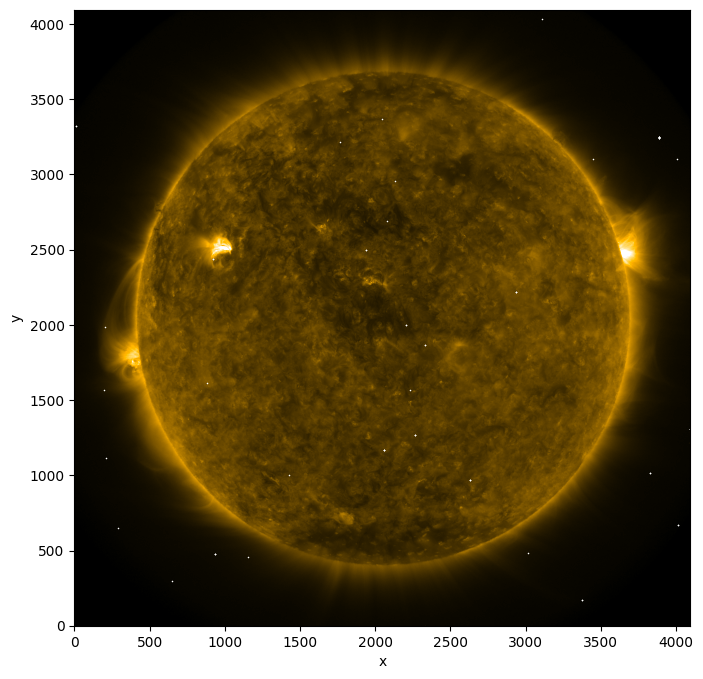

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df0.query('overlaps==7'), x='x', y='y', ax=ax, color='white', s=1, alpha=1)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=spikes, x='x', y='y', ax=ax, s=1, color='white',
                label='all spikes')


sns.scatterplot(data=spikes_w5, x='x', y='y', 
                hue='min_overlaps',
                size='min_overlaps',
                sizes=(20, 100),
                palette=sns.color_palette(['cyan', 'red']),
                ax=ax)



plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

leg = plt.legend(loc='upper right', fancybox=True, framealpha=1, facecolor='black')
texts = ['all spikes', '>= 2 overlaps', '>=3 overlaps']
for i, text in enumerate(leg.get_texts()):
    text.set_color("white")
    text.set_text(texts[i])

In [ ]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)), 
           zorder=0)

plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_xlabel('X-axis [px]', fontsize=FS-2)
ax.set_ylabel('Y-axis [px]', fontsize=FS-2)
ax.set_title('SDO/AIA 171 ', loc='left', fontsize=FS)

# # Overlay spikes
plt.scatter(spikes['x'], spikes['y'], s=0.5, facecolors='white', edgecolors='white', label='all spikes', alpha=0.5, zorder=1)

plt.scatter(spikes_slice['x'], spikes_slice['y'], s=40, lw=2, facecolors='none', edgecolors='r', label='>=3 overlap', alpha=0.5, zorder=2)

white_circles = mlines.Line2D([], [], color='white', marker='o', linestyle='None',
                          markersize=5, label='all spikes')
red_circles = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markerfacecolor='none',
                          markeredgewidth=2, markersize=10, label='>=3-overlap')

leg = plt.legend(handles=[white_circles, red_circles],
    loc='upper right', fancybox=True, framealpha=1, facecolor='black')


for text in leg.get_texts():
    text.set_color("white")

#     handle._legmarker.set_alpha(1)
# # plt.savefig('figures/overlap_5.png', dpi=120)   


In [ ]:
leg.legend_handles[0]

In [ ]:
coords3 = df0.loc[seriesccount==3]['coords'].values
coords_x3 = coords3 % 4096
coords_y3 = coords3 // 4096

coords5 = df0.loc[seriesccount==5]['coords'].values
coords_x5 = coords5 % 4096
coords_y5 = coords5 // 4096


fig, ax = plt.subplots(figsize=(15,14))
plt.imshow(img, origin='lower', vmin=1, vmax=np.percentile(img, 99.9), 
           cmap=cmap, norm=colors.PowerNorm(gamma=0.6), zorder=0)

ax.set_facecolor('black')
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
plt.plot(coords_x3, coords_y3, 'w.', ms=2, label='3-wlgth-overlap', zorder=1, alpha=0.1)
plt.plot(coords_x5, coords_y5, 'rd', ms=6, markerfacecolor='none', label='5-wlgth-overlap', zorder=2)
#sdisk = plt.Circle((crpix, crpix), r_sun, color='orange', fill=False, linewidth=2, zorder=2)
#ax.add_artist(sdisk)
#plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
leg = plt.legend(fontsize=FS, loc='upper right', fancybox=True, framealpha=1, facecolor='black')
for text in leg.get_texts():
    text.set_color("white")
for handle in leg.legendHandles:
    handle._legmarker.set_markersize(6)
    handle._legmarker.set_alpha(1)
    
plt.xlabel('X [px]', fontsize=FS)
plt.ylabel('Y [px]', fontsize=FS)

ax.set_title('SDO/AIA 171 - spikes over 1 day - wavelengths coincidences', loc='left', fontsize=FS+2)


props = dict(boxstyle='round', facecolor='black', alpha=0.8)
ax.text(0.54, 0.065, mycredits, transform=ax.transAxes, fontsize=FS,
        verticalalignment='top', bbox=props, color='white')

plt.tight_layout()
plt.savefig('figures/overlap_3_5.png', dpi=120)

In [ ]:
len(coords3)

### Design method to extract unique coincidental events, lifting any ambiguity (conjugates, redundancies, ...)

In [ ]:
w1_idx = 4
w2_idx = 5
w3_idx = 6
w4_idx = 7

In [ ]:
groups = df0.index.unique()

In [ ]:
events12 = [get_2clusters(df0.loc[group_n].values, w1_idx, w2_idx, group_n) for group_n in groups]
df_events12 = pd.concat(events12)
df_events12 = df_events12.loc[(df_events12.wref2 == 1)]
print(len(events12))
df_events12.head()

In [ ]:
events14 = [get_2clusters(df0.loc[group_n].values, w1_idx, w4_idx, group_n) for group_n in groups]
df_events14 = pd.concat(events14)
df_events14 = df_events14.loc[(df_events14.wref2 == 3)]
df_events14.head()

In [ ]:
c12 = df_events12.groupby('GroupNumber').size().rename('coincidentals count for Wav 0 & Wav 1')
dfcount12 = pd.concat([gdates.loc[groups], c12], axis=1)
dfcount12.set_index('Time', inplace=True)
dfcount12.head()

In [ ]:
%matplotlib inline
ax = dfcount12.plot(figsize=(8,8), fontsize=14)
ax.legend(fontsize=16)

In [ ]:
# gn = groups[0]

# coords1 = df_events12.loc[df_events12['GroupNumber']==gn]['coords1'].values
# coords1 = df_events12['coords1'].values
# coords_x1 = coords1 % 4096
# coords_y1 = coords1 // 4096

# coords2 = df_events12.loc[df_events12['GroupNumber']==gn]['coords2'].values
# coords_x2 = coords2 % 4096
# coords_y2 = coords2 // 4096

In [ ]:
coords1 = df_events12['coords1'].values
coords_x1 = coords1 % 4096
coords_y1 = coords1 // 4096

sdisk = plt.Circle((crpix, crpix), r_sun, color='black', fill=False)
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
ax.add_artist(sdisk)
plt.plot(coords_x1, coords_y1, 'r.', ms=4, markerfacecolor='none', label='Wave 1')
#plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
plt.legend(fontsize=16, loc='upper right')